# Prediction heart disease using Machine Learning

**Data Set Information:**

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to
this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [150]:
heart_disease = pd.read_csv('..\data\heart-disease.csv')
heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [151]:
print(heart_disease.dtypes)

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


In [152]:
print(heart_disease.isna().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [153]:
heart_disease['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

**Find a correlation**

In [154]:
heart_disease.corr()['target'].sort_values(ascending=False)

target      1.000000
cp          0.433798
thalach     0.421741
slope       0.345877
restecg     0.137230
fbs        -0.028046
chol       -0.085239
trestbps   -0.144931
age        -0.225439
sex        -0.280937
thal       -0.344029
ca         -0.391724
oldpeak    -0.430696
exang      -0.436757
Name: target, dtype: float64

sex (1 = male; 0 = female)

In [155]:
heart_disease['sex'].value_counts()

1    207
0     96
Name: sex, dtype: int64

In [156]:
sex_target = pd.crosstab(heart_disease['sex'], heart_disease['target'])
sex_target

target,0,1
sex,,
0,24,72
1,114,93


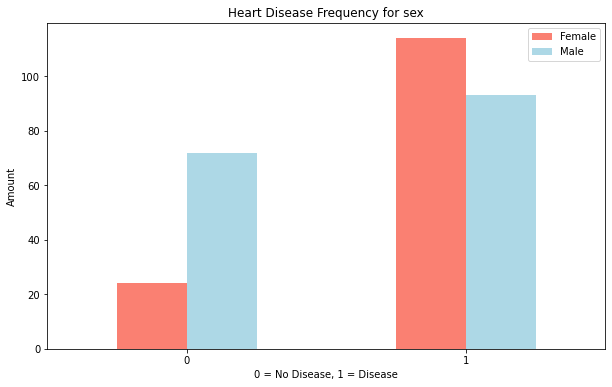

In [157]:
sex_target.plot(
    kind='bar', figsize=(10,6), color=['salmon','lightblue'])

plt.title('Heart Disease Frequency for sex')
plt.xlabel('0 = No Disease, 1 = Disease')
plt.ylabel('Amount')
plt.legend(['Female','Male'])
plt.xticks(rotation=0); # rotation x ticks 

## Scaling data with StandardScaler

In [158]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

X = heart_disease.drop('target', axis=1)
y = heart_disease['target']

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=.2, random_state=42)

attributs_cols = list(X.columns)

scaler  = StandardScaler()
preprocessor = ColumnTransformer([ 
    ('numerical',scaler,attributs_cols),
])

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [159]:
np.array(X_train.iloc[0])

array([ 42.,   1.,   1., 120., 295.,   0.,   1., 162.,   0.,   0.,   2.,
         0.,   2.])

In [160]:
X_train_transformed[0]

array([-1.35679832,  0.72250438,  0.00809909, -0.61685555,  0.91403366,
       -0.38330071,  0.8431327 ,  0.53278078, -0.67663234, -0.92086403,
        0.95390513, -0.68970073, -0.50904773])

## Now we going to try 3 estimators.
1. LogisticRegression
2. K nearest neighbor classifier
3. RandomForest classifier
4. Support Vector Machine classifier

In [161]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

estimators = {
    'Logistic':LogisticRegression(),
    'Knn':KNeighborsClassifier(),
    'RandomForest':RandomForestClassifier(),
    'SVC':SVC()
}

def fit_and_score(models,X_train,X_test,y_train,y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [162]:
model_scores = fit_and_score(estimators,X_train_transformed,X_test_transformed,y_train,y_test)
model_comparison = pd.DataFrame(model_scores, index=['accuracy'])
model_comparison.T['accuracy'].sort_values(ascending=False)

Knn             0.901639
SVC             0.868852
Logistic        0.852459
RandomForest    0.836066
Name: accuracy, dtype: float64

> the baseline model(Knn) with 90% accuracy 

## Hyperparameter Tuning

In [196]:
from sklearn.model_selection import RandomizedSearchCV

params_knn = {
    'n_neighbors':np.arange(2,22),
    'weights': ['uniform', 'distance'],
    'algorithm':['auto','ball_tree','kd_tree','brute']
}

params_SVC = {
    'C':np.logspace(-4,4,10),
    'kernel':['linear','rbf','sigmoid'],
    'gamma':['scale','auto']
}

params_logistic = {
    'C':np.logspace(-4,4,10),
    'penalty':['l2'],
    'solver':['newton-cg','lbfgs']
}

params_rdf = {
    'n_estimators':np.arange(10,210,10),
    'max_features':['sqrt','log2',None]
}

hyperparams = [params_logistic, params_knn, params_rdf, params_SVC]

In [197]:
model_scores_params = {}
np.random.seed(42)
for model, params in zip(estimators.items(), hyperparams) :
    search = RandomizedSearchCV(model[1], params, cv=5, n_iter=20, verbose=0)
    search.fit(X_train_transformed, y_train)
    model_scores_params[model[0]] = search.score(X_test_transformed, y_test)

In [198]:
model_scores_params

{'Logistic': 0.8524590163934426,
 'Knn': 0.8852459016393442,
 'RandomForest': 0.8688524590163934,
 'SVC': 0.8852459016393442}

> Look like Knn and SVC is the best estimators try to improve it.

Technically: Because score is quite worse, searchCV creates subsamples of the data repeatedly. That means the SVC is trained on 80% of x_train in each iteration and the results are the mean of predictions on the other 20%.

In [204]:
from sklearn.model_selection import GridSearchCV

np.random.seed(42)
knn_model = KNeighborsClassifier(n_jobs=-1)
params_knn = {
    'n_neighbors':np.arange(1,50),
    'weights': ['uniform', 'distance'],
    'algorithm':['auto','ball_tree','kd_tree','brute']
}
Grid_knn = GridSearchCV(knn_model, params_knn, cv=5, n_jobs=-1)
Grid_knn.fit(X_train_transformed, y_train)
Grid_knn.score(X_test_transformed, y_test)

0.8852459016393442

In [205]:

np.random.seed(42)
svc_model = SVC()
params_SVC = {
    'C':np.logspace(-4,4,30),
    'kernel':['linear','rbf','sigmoid'],
    'gamma':['scale','auto']
}
Grid_svc = GridSearchCV(svc_model, params_SVC, cv=5, n_jobs=-1)
Grid_svc.fit(X_train_transformed, y_train)
Grid_svc.score(X_test_transformed, y_test)

0.8688524590163934

In [206]:
Grid_knn.best_params_

{'algorithm': 'auto', 'n_neighbors': 16, 'weights': 'uniform'}

> KNeighborsClassifier is better.

### See the metrics score

In [213]:
Knn_estimators = KNeighborsClassifier(**Grid_knn.best_params_)
Knn_estimators.fit(X_train_transformed, y_train)
y_preds = Knn_estimators.predict(X_test_transformed)

In [223]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.88      0.89        32

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



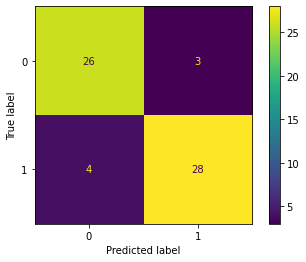

In [230]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_preds);

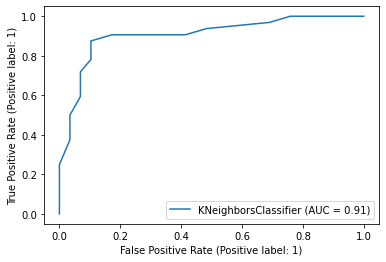

In [232]:
from sklearn.metrics._plot.roc_curve import RocCurveDisplay

RocCurveDisplay.from_estimator(Knn_estimators,X_test_transformed, y_test);

### Calculate evaluation metrics using cross-validation

In [256]:
from sklearn.model_selection import cross_val_score

Knn_cv = KNeighborsClassifier(**Grid_knn.best_params_)

scoring = []
for score in ['accuracy','precision','recall','f1']:
    scores = np.mean(cross_val_score(Knn_cv, X_train_transformed, y_train , cv=5, scoring=score))
    scoring.append({score:scores})

scoring

[{'accuracy': 0.8306972789115645},
 {'precision': 0.807200460829493},
 {'recall': 0.9094017094017094},
 {'f1': 0.8549429616641774}]

In [331]:
Knn_estimators.score(X_test_transformed, y_test)

0.8852459016393442